In [1]:
# https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data
# https://www.kaggle.com/datasets/omarhanyy/imdb-top-1000
# https://www.kaggle.com/datasets/tanuprabhu/population-by-country-2020

In [2]:
# 1. Imports & Configuration
import warnings
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

# PySpark Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, explode, year, count, avg, desc, 
    regexp_replace, when, expr, lower, trim
)
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

# Configuration
warnings.filterwarnings("ignore")
DATA_PATH = "data/"

# Initialize Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GlobalMovieTrends_Final") \
    .getOrCreate()

print("Spark Session succesfully initialized.")

Spark Session succesfully initialized.


In [3]:
## 1. Data Ingestion

In [4]:
def load_csv(filename):
    """Helper function to load CSVs with header and schema inference."""
    path = f"{DATA_PATH}{filename}"
    return spark.read.option("header", True).option("inferSchema", True).csv(path)

# Load Datasets
try:
    movies_metadata = load_csv("movies_dataset/movies_metadata.csv")
    population_by_country = load_csv("population_by_country/population_by_country_2020.csv")
    imdb_top_1000 = load_csv("imdb_top_1000/IMDB top 1000.csv")
    print("Datasets loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}. Please check your DATA_PATH.")

Datasets loaded successfully.


In [5]:
## 2. Technical Analysis: RDDs (Unstructured Data)

In [6]:
# Function to parse genre strings using AST (Abstract Syntax Tree)
def parse_genres(row):
    try:
        if not row.genres: return []
        data = ast.literal_eval(row.genres) # Safely evaluate string as list
        return [item['name'] for item in data]
    except:
        return []

# RDD Pipeline: Filter -> Map -> FlatMap -> Map -> ReduceByKey -> Sort
print(f"Processing {movies_metadata.count()} movies using RDDs...")

rdd_genres = movies_metadata.select("genres").rdd \
    .filter(lambda row: row.genres is not None) \
    .map(parse_genres) \
    .flatMap(lambda x: x) \
    .map(lambda genre: (genre, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending=False)

# Display Top 5
print("\nTop 5 Genres (Calculated via RDD):")
for genre, count_val in rdd_genres.take(5):
    print(f"- {genre}: {count_val}")

Processing 45572 movies using RDDs...

Top 5 Genres (Calculated via RDD):
- Drama: 20239
- Comedy: 13123
- Thriller: 7612
- Romance: 6722
- Action: 6581


In [7]:
## 3. Data Transformation (ETL)

In [8]:
# 1. Clean Movies Metadata
# Fix malformed JSON quotes and define schema
movies_clean = movies_metadata.withColumn(
    "production_countries", 
    regexp_replace(col("production_countries"), "'", '"')
)

country_schema = ArrayType(StructType([
    StructField("iso_3166_1", StringType()),
    StructField("name", StringType())
]))

# Parse JSON and Explode (One row per country per movie)
movies_exploded = movies_clean \
    .withColumn("countries_struct", from_json(col("production_countries"), country_schema)) \
    .select(
        col("title"),
        year(col("release_date")).alias("release_year"),
        col("vote_average"),
        explode(col("countries_struct")).alias("country_info")
    ) \
    .select(
        col("title"),
        col("release_year"),
        col("vote_average"),
        col("country_info.iso_3166_1").alias("country_code"),
        col("country_info.name").alias("country_name")
    ) \
    .filter(col("country_code").isNotNull())

# 2. Prepare Population Data
# Normalize column names and fix 'United States' naming mismatch
population_clean = population_by_country \
    .withColumnRenamed("Country (or dependency)", "pop_country_name") \
    .withColumnRenamed("Population (2020)", "population") \
    .withColumn("pop_country_name", 
        when(col("pop_country_name") == "United States", "United States of America")
        .otherwise(col("pop_country_name"))
    )

# 3. Join & Cast
# Inner join to associate population with movies
df_enriched = movies_exploded.join(
    population_clean,
    movies_exploded.country_name == population_clean.pop_country_name,
    "inner"
)

# Robust type casting for ratings (handle malformed strings using try_cast)
df_enriched = df_enriched \
    .withColumn("vote_average", expr("try_cast(vote_average as double)")) \
    .filter(col("vote_average").isNotNull())

print("Data transformation complete. Schema:")
df_enriched.printSchema()

Data transformation complete. Schema:
root
 |-- title: string (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- pop_country_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- Yearly Change: string (nullable = true)
 |-- Net Change: integer (nullable = true)
 |-- Density (P/Km²): integer (nullable = true)
 |-- Land Area (Km²): integer (nullable = true)
 |-- Migrants (net): double (nullable = true)
 |-- Fert. Rate: string (nullable = true)
 |-- Med. Age: string (nullable = true)
 |-- Urban Pop %: string (nullable = true)
 |-- World Share: string (nullable = true)



In [9]:
## 4. Analysis: Quantity (Movies per Capita)

In [10]:
# Aggregate: Total movies and average rating per country
films_per_country = df_enriched.groupBy("country_name", "country_code", "population") \
    .agg(
        count("title").alias("total_movies"), 
        avg("vote_average").alias("avg_rating")
    )

# Calculate Per Capita Metric (Movies per 100k citizens)
# Filter: Only include countries with > 50 movies to reduce noise
analysis_per_capita = films_per_country \
    .withColumn("movies_per_100k", (col("total_movies") / col("population")) * 100000) \
    .filter(col("total_movies") > 50) \
    .orderBy(desc("movies_per_100k"))

print("Top 10 Countries by Movie Production per Capita:")
analysis_per_capita.show(10)

Top 10 Countries by Movie Production per Capita:
+--------------------+------------+----------+------------+------------------+------------------+
|        country_name|country_code|population|total_movies|        avg_rating|   movies_per_100k|
+--------------------+------------+----------+------------+------------------+------------------+
|             Iceland|          IS|    341628|          64| 6.074999999999999|18.733827438032012|
|          Luxembourg|          LU|    627704|          76| 5.563157894736842| 12.10761760320151|
|           Hong Kong|          HK|   7507523|         521| 6.204030710172744| 6.939705679223361|
|             Finland|          FI|   5542237|         358| 5.259217877094972| 6.459485583167952|
|             Denmark|          DK|   5795780|         361|6.1551246537396125| 6.228669825286675|
|United States of ...|          US| 331341050|       19287| 5.594540363975729| 5.820890589922377|
|      United Kingdom|          GB|  67948282|        3814| 6.0179077

In [11]:
## 5. Analysis: Quality (Spark SQL Integration)

In [12]:
# A. Prepare Data (Regex Cleaning for Titles)
imdb_clean = imdb_top_1000.select(
    col("Title").alias("raw_title"), 
    col("Rate").alias("imdb_rating")
) \
.withColumn("clean_title", regexp_replace(col("raw_title"), "^[0-9]+\\.\\s", "")) \
.withColumn("clean_title", regexp_replace(col("clean_title"), "\\s\\([0-9]{4}\\)$", "")) \
.withColumn("join_key", lower(trim(col("clean_title"))))

df_enriched_join = df_enriched.withColumn("join_key", lower(trim(col("title"))))

# B. Register Temporary Views for SQL
df_enriched_join.createOrReplaceTempView("movies_view")
imdb_clean.createOrReplaceTempView("imdb_view")

# C. Execute Spark SQL Query
print("Executing SQL Query for Top Rated Movies...")
sql_result = spark.sql("""
    SELECT 
        m.country_name, 
        COUNT(m.title) as num_top_movies
    FROM movies_view m
    JOIN imdb_view i ON m.join_key = i.join_key
    GROUP BY m.country_name
    ORDER BY num_top_movies DESC
""")

sql_result.show(10)

Executing SQL Query for Top Rated Movies...
+--------------------+--------------+
|        country_name|num_top_movies|
+--------------------+--------------+
|United States of ...|           521|
|      United Kingdom|           129|
|               India|            91|
|              France|            86|
|             Germany|            74|
|               Japan|            55|
|               Italy|            51|
|           Hong Kong|            32|
|         South Korea|            32|
|              Sweden|            27|
+--------------------+--------------+
only showing top 10 rows


In [13]:
## 6. Visualizations & Dashboard

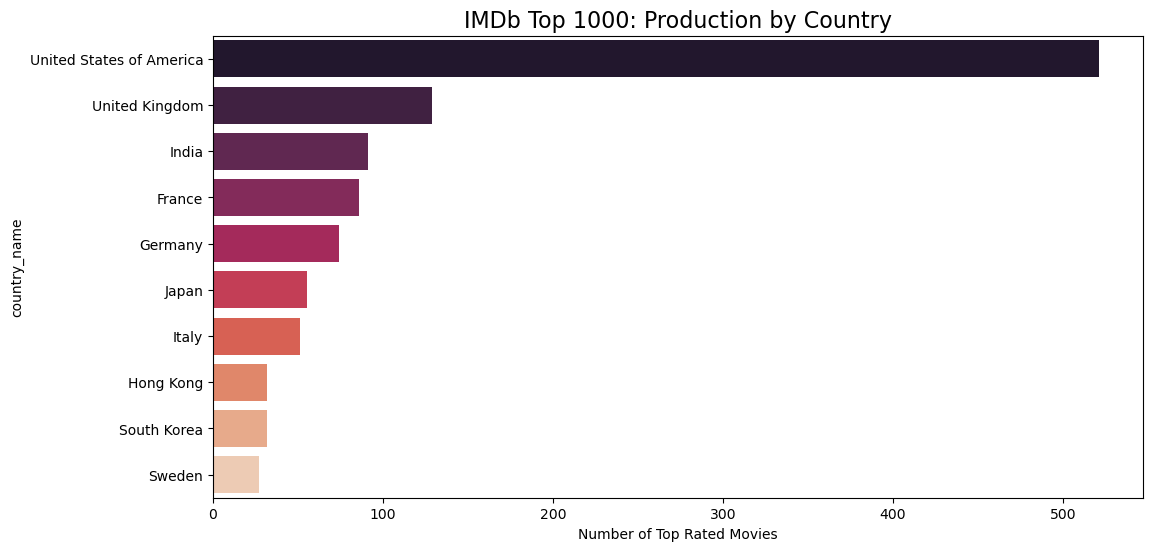


Interactive Dashboard:


interactive(children=(IntSlider(value=10, description='top_n', max=20, min=5), Output()), _dom_classes=('widge…

In [14]:
# 1. Seaborn Barplot (Quality)
pdf_quality = sql_result.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=pdf_quality, x="num_top_movies", y="country_name", 
    palette="rocket", hue="country_name", legend=False
)
plt.title("IMDb Top 1000: Production by Country", fontsize=16)
plt.xlabel("Number of Top Rated Movies")
plt.show()

# 2. Plotly Choropleth Map (Quantity)
pdf_map = analysis_per_capita.toPandas()

fig = px.choropleth(
    pdf_map,
    locations="country_name", locationmode='country names',
    color="movies_per_100k",
    hover_name="country_name", hover_data=["total_movies", "population"],
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Global Movie Production per 100k Inhabitants"
)
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show(renderer="iframe")

# 3. Interactive Dashboard Widget
print("\nInteractive Dashboard:")
def plot_interactive(top_n):
    subset = pdf_quality.head(top_n)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=subset, x="num_top_movies", y="country_name", 
        palette="viridis", hue="country_name", legend=False
    )
    plt.title(f"Top {top_n} Countries (IMDb Top 1000)", fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

interact(plot_interactive, top_n=widgets.IntSlider(min=5, max=20, step=1, value=10));